# **Importing necessary Packages and defining paths**

In [3]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_mobilenet
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, RepeatVector, dot, Activation
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Define paths
train_images_path1 = '/content/drive/MyDrive/train'  # Path to the first set of training images
train_images_path2 = '/content/drive/MyDrive/train2' # Path to second set of training images
train_image_paths3 = '/content/drive/MyDrive/train2'  # Path to the second set of training images
valid_images_path = '/content/drive/MyDrive/valid'  # Path to the validation images
test_images_path = '/content/drive/MyDrive/test'  # Path to the test images
train_annotations_path1 = '/content/train_combined.json'  # Path to the first set of training annotations
train_annotations_path2 = '/content/train2_combined.json'
train_annotations_path3 = '/content/sr_updated.json'  # Path to the second set of training annotations
valid_annotations_path = '/content/valid_combined.json'  # Path to the validation annotations
test_annotations_path = '/content/test_combined.json'  # Path  to the test annotations

# **Mounting google drive for dataset paths**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Annotations,Images and Extracting features**

In [4]:
def load_annotations(file_path):
    with open(file_path, 'r') as file:
        annotations = json.load(file)
    return annotations

# Load annotations
train_annotations1 = load_annotations(train_annotations_path1)
train_annotations2 = load_annotations(train_annotations_path2)
train_annotations3 = load_annotations(train_annotations_path3)
valid_annotations = load_annotations(valid_annotations_path)
test_annotations = load_annotations(test_annotations_path)

def load_images(directory, target_size=(224, 224)):
    images = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        if os.path.isdir(img_path):
            continue
        try:
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            img = img / 255.0  # Normalize image
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(images)

def extract_features_with_mobilenet(directory):
    model = MobileNetV2(include_top=False, pooling='avg')
    features = {}
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        if os.path.isdir(img_path):
            continue
        try:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_mobilenet(img)

            feature = model.predict(img, verbose=0)
            features[img_name] = feature.flatten()
        except Exception as e:
            print(f"Error extracting features for image {img_path}: {e}")

    return features

# Extract features
train_features1 = extract_features_with_mobilenet(train_images_path1)
train_features2 = extract_features_with_mobilenet(train_images_path2)
train_features3 = extract_features_with_mobilenet(train_image_paths3)
valid_features = extract_features_with_mobilenet(valid_images_path)
test_features = extract_features_with_mobilenet(test_images_path)

<ipython-input-4-4f3422ecbcf9>:29: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **Flattening annotations and Preprocessing Captions**

In [5]:
def flatten_annotations(annotations):
    flattened_annotations = []
    for img_annotations in annotations:
        for annotation in img_annotations:
            flattened_annotations.append(annotation)
    return flattened_annotations

def preprocess_captions(annotations):
    captions = {}
    for item in annotations:
        if isinstance(item, dict):  # Ensure item is a dictionary
            img_path = item['image_path']
            img_name = os.path.basename(img_path)
            if img_name not in captions:
                captions[img_name] = []
            captions[img_name].append('startseq ' + item['A'] + ' endseq')
    return captions

# Flatten and preprocess annotations
train_annotations1_flat = flatten_annotations(train_annotations1)
train_annotations2_flat = flatten_annotations(train_annotations2)
train_annotations3_flat = flatten_annotations(train_annotations3)
valid_annotations_flat = flatten_annotations(valid_annotations)
test_annotations_flat = flatten_annotations(test_annotations)

train_captions1 = preprocess_captions(train_annotations1_flat)
train_captions2 = preprocess_captions(train_annotations2_flat)
train_captions3 = preprocess_captions(train_annotations3_flat)
valid_captions = preprocess_captions(valid_annotations_flat)
test_captions = preprocess_captions(test_annotations_flat)

# **Tokenisation**

In [6]:
all_captions = [item for sublist in [train_captions1.values(), train_captions2.values(), train_captions3.values(), valid_captions.values(), test_captions.values()] for item in sublist]
all_captions_flat = [caption for sublist in all_captions for caption in sublist]

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions_flat)

# Adding special tokens
tokenizer.word_index['startseq'] = len(tokenizer.word_index) + 1
tokenizer.word_index['endseq'] = len(tokenizer.word_index) + 1
vocab_size = len(tokenizer.word_index) + 1

# Maximum length of captions
max_length = max(len(desc.split()) for desc in all_captions_flat)

# **Creating Sequences for Model Training**

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():
        if key not in photos:
            continue
        photo = photos[key]
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                if out_seq < vocab_size:
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


# Create sequences for each dataset
X1train1, X2train1, ytrain1 = create_sequences(tokenizer, max_length, train_captions1, train_features1, vocab_size)
X1train2, X2train2, ytrain2 = create_sequences(tokenizer, max_length, train_captions2, train_features2, vocab_size)
X1train3, X2train3, ytrain3 = create_sequences(tokenizer, max_length, train_captions3, train_features3, vocab_size)
X1val, X2val, yval = create_sequences(tokenizer, max_length, valid_captions, valid_features, vocab_size)

# Combine all training data, handle empty arrays
X1train = np.concatenate([X1train1, X1train2, X1train3], axis=0) if X1train2.size > 0 else X1train1
X2train = np.concatenate([X2train1, X2train2, X2train3], axis=0) if X2train2.size > 0 else X2train1
ytrain = np.concatenate([ytrain1, ytrain2, ytrain3], axis=0) if ytrain2.size > 0 else ytrain1

# **Defining and Training Model**

In [8]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, RepeatVector, Concatenate, Activation, dot, Bidirectional
from tensorflow.keras.models import Model
import tensorflow as tf

def define_attention_model(vocab_size, max_length):
    # Feature extractor model
    inputs1 = Input(shape=(1280,))  # Input layer for the image features
    fe1 = Dropout(0.5)(inputs1)  # Dropout for regularization from preventing overfitting
    fe2 = Dense(256, activation='relu')(fe1)  # Dense layer to process the image features
    fe3 = RepeatVector(max_length)(fe2)  # Repeat vector to match the length of the sequences

    # Sequence model
    inputs2 = Input(shape=(max_length,))  # Input layer for the sequences
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)  # Embedding layer to process the input sequences
    # Embedding layer establishes semantic relationship between words
    # mask_zero ignores mask padded zeroes to match the length of the string
    se2 = Dropout(0.5)(se1)  # Dropout for regularization
    se3 = LSTM(256, return_sequences=True)(se2)  # LSTM layer to process the sequences
    # LSTM processes the information at each time step and maintains a hidden state, which is then used by the attention mechanism to focus on relevant parts of the sequence when generating the next word

    # Attention mechanism
    attn = dot([se3, fe3], axes=[2, 2])  # Calculate dot product for attention scores
    attn = Activation('softmax')(attn)  # Apply softmax to get attention weights
    context = dot([attn, fe3], axes=[2, 1])  # Calculate context vector

    # Decoder model
    decoder1 = add([context, se3])  # Combine context vector and sequence model output
    decoder2 = LSTM(256)(decoder1)  # LSTM layer to process the combined input
    outputs = Dense(vocab_size, activation='softmax')(decoder2)  # Output layer to predict the next word

    # Combine models
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)  # Define the model with image and sequence inputs
    model.compile(loss='categorical_crossentropy', optimizer='adam')  # Compile the model with categorical cross-entropy loss and Adam optimizer
    return model  # Return the compiled model

# Define and train the model
model = define_attention_model(vocab_size, max_length)  # Define the attention model with the vocabulary size and maximum length
model.fit([X1train, X2train], ytrain, epochs=30, batch_size=64, validation_data=([X1val, X2val], yval))  # Train the model with training data and validate with validation data

Epoch 1/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 3.7005 - val_loss: 3.6612
Epoch 2/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 3.5800 - val_loss: 3.5954
Epoch 3/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 3.5258 - val_loss: 3.5468
Epoch 4/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 3.4670 - val_loss: 3.4010
Epoch 5/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 3.2114 - val_loss: 2.2250
Epoch 6/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 1.7092 - val_loss: 1.1945
Epoch 7/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 1.0138 - val_loss: 1.0021
Epoch 8/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.8320 - val_loss: 0.8945
Epoch 9/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.7006 - val_loss: 0.8285
Epoch 10/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.6092 - val_loss: 0.8014
Epoch 11/30
616/616 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.5467 - val_loss: 0.7603
Epoch 12/30
616/616 ━━━━━━━━━━━━

In [9]:
model_path = '/content/drive/MyDrive/attention_qa_model.h5'
model.save(model_path)

# **Caption Generation with Beam search and Post processing**

Generating Captions for Test Images:


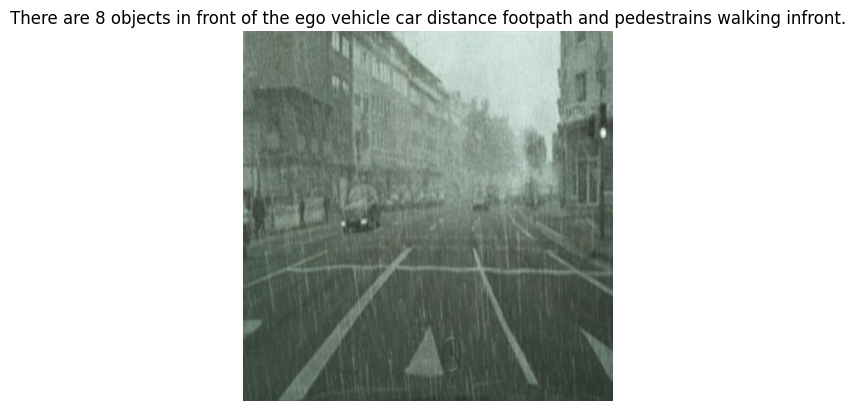

Image ID: c_to_r_293_to_0_8_jpg.rf.a8b729f29d7135ab8d989f64aee06bc0.jpg
Predicted Caption: There are 8 objects in front of the ego vehicle car distance footpath and pedestrains walking infront.



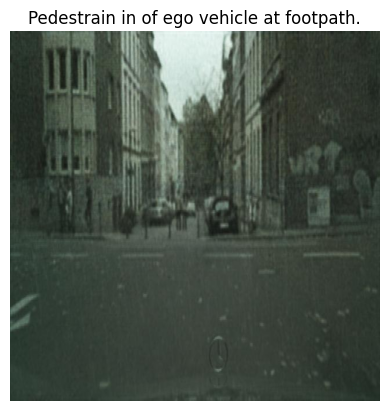

Image ID: c_to_r_296_to_3_2_jpg.rf.0dc606f7f0beae81e3af9addee0634ff.jpg
Predicted Caption: Pedestrain in of ego vehicle at footpath.



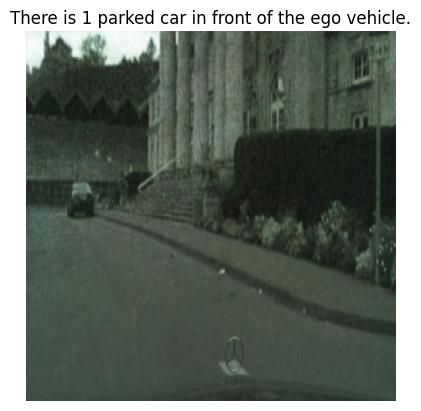

Image ID: c_to_r_294_to_1_1_jpg.rf.5d6d8141a969b34a0a4ba404065e4bb7.jpg
Predicted Caption: There is 1 parked car in front of the ego vehicle.



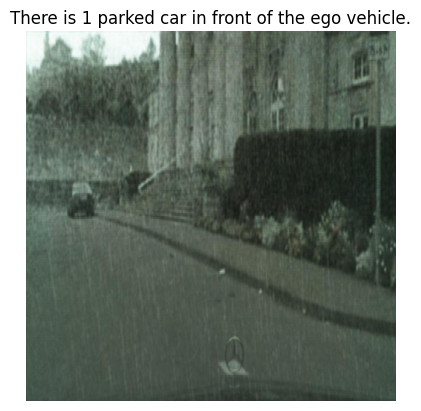

Image ID: c_to_r_294_to_1_4_jpg.rf.27da486166b58983edabd974ff424ec5.jpg
Predicted Caption: There is 1 parked car in front of the ego vehicle.



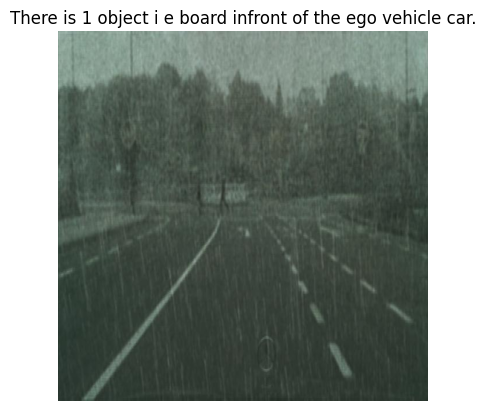

Image ID: c_to_r_350_to_57_7_jpg.rf.bd780cb867a8da5a2e7774494c5e348b.jpg
Predicted Caption: There is 1 object i e board infront of the ego vehicle car.



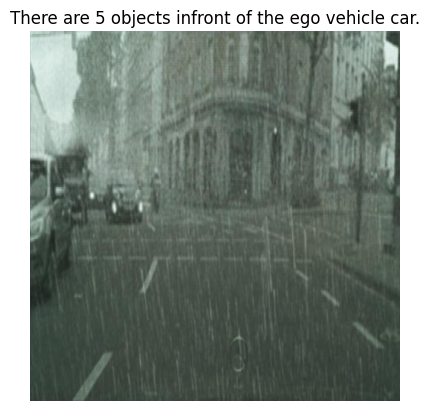

Image ID: c_to_r_301_to_8_8_jpg.rf.ebd7480f6dc492f01e0bf0aa6c4a1cbe.jpg
Predicted Caption: There are 5 objects infront of the ego vehicle car.



In [15]:
import numpy as np
import spacy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

def beam_search_caption(model, tokenizer, photo, max_length, beam_width=3):
    start_token = tokenizer.word_index['startseq']
    end_token = tokenizer.word_index['endseq']
    start = [start_token]  # Initialize starting sequence with 'startseq' token
    start_word = [[start, 0.0]]  # Initialize starting word with sequence and initial probability

    while len(start_word[0][0]) < max_length:  # Loop until maximum length of sequence is reached
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_length, padding='post')  # Pad the sequence to max_length with padding='post'
            yhat = model.predict([photo, sequence], verbose=0)  # Predict next word probabilities
            word_preds = np.argsort(yhat[0])[-beam_width:]  # Get top beam_width word indices

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]  # Copy current sequence and probability
                next_cap.append(w)  # Append next word index
                prob += np.log(yhat[0][w] + 1e-9)  # Update probability using log likelihood
                temp.append([next_cap, prob])  # Append new sequence and probability

        start_word = temp  # Update sequences with new predictions
        start_word = sorted(start_word, reverse=True, key=lambda l: l[1])  # Sort sequences by probability
        start_word = start_word[:beam_width]  # Select top sequences based on beam_width

        # Check if any sequence ends with the end_token
        end_sequences = [seq for seq in start_word if seq[0][-1] == end_token]
        if end_sequences:
            break

    # If no sequence ends with end_token, take the sequence with the highest probability
    if not end_sequences:
        best_sequence = start_word[0][0]
    else:
        best_sequence = min(end_sequences, key=lambda x: x[1])[0]

    intermediate_caption = []
    for i in best_sequence:
        word = tokenizer.index_word.get(i, '')
        if word == 'endseq':
            break
        intermediate_caption.append(word)

    # Convert list of words to a string caption
    final_caption = ' '.join(intermediate_caption[1:])  # Join words into final caption
    final_caption = post_process_caption(final_caption)  # Post-process caption for cleanup
    return final_caption  # Return the final processed caption

def post_process_caption(caption):
    # Process the caption with spaCy
    doc = nlp(caption)

    # Initialize the final_caption
    final_caption = []

    # Process each sentence to clean and structure
    for sent in doc.sents:
        # Strip unnecessary spaces and add the sentence to the final_caption list
        sentence = sent.text.strip()

        # Remove redundant numbers and words
        sentence = remove_redundant_numbers(sentence)
        sentence = remove_repeated_words(sentence)
        sentence = remove_repeated_phrases(sentence)

        # Remove unwanted ending prepositions or conjunctions
        sentence = remove_unwanted_endings(sentence)

        # Append cleaned sentence
        if sentence:
            final_caption.append(sentence)

    # Join the sentences with space and ensure proper capitalization and punctuation
    final_caption = ' '.join(final_caption).capitalize()
    final_caption = ensure_proper_end(final_caption)

    return final_caption  # Return the final processed caption

def remove_redundant_numbers(sentence):
    words = sentence.split()
    result = []

    # Avoid appending numbers that don't make sense
    for word in words:
        if not word.isdigit() or (word.isdigit() and (len(result) > 0 and not result[-1].isdigit())):
            result.append(word)

    return ' '.join(result)

def remove_repeated_words(sentence):
    words = sentence.split()
    seen = set()
    result = []

    for word in words:
        if word.lower() not in seen:
            result.append(word)
            seen.add(word.lower())

    return ' '.join(result)

def remove_repeated_phrases(sentence):
    words = sentence.split()
    result = []
    i = 0
    while i < len(words):
        phrase = ' '.join(words[i:i+2])
        if i + 1 < len(words) and phrase in sentence:
            if i + 2 < len(words) and ' '.join(words[i:i+3]) == phrase:
                # Skip repeated phrases
                i += 1
            else:
                result.append(words[i])
        else:
            result.append(words[i])
        i += 1

    return ' '.join(result)

def remove_unwanted_endings(sentence):
    unwanted_endings = {'and', 'or', 'but', 'with', 'of', 'at', 'in', 'on', 'to', 'for', 'by'}
    words = sentence.split()

    # Remove unwanted conjunctions/prepositions at the end
    while words and words[-1].lower() in unwanted_endings:
        words.pop()

    return ' '.join(words)

def ensure_proper_end(caption):
    # Ensure the caption ends with proper punctuation
    if not caption:
        return caption

    last_char = caption[-1]
    if last_char not in {'.', '!', '?'}:
        caption += '.'

    return caption

def generate_and_display_captions(test_features, model, tokenizer, max_length, test_images_path, num_images=6):
    print("Generating Captions for Test Images:")
    idx = 0
    for image_id, feature in test_features.items():
        if idx >= num_images:
            break
        caption = beam_search_caption(model, tokenizer, np.expand_dims(feature, axis=0), max_length)
        img_path = os.path.join(test_images_path, image_id)  # Get image path
        display_image_caption(img_path, caption)  # Display image with caption
        print(f"Image ID: {image_id}")
        print(f"Predicted Caption: {caption}")  # Print predicted caption
        print()
        idx += 1

def display_image_caption(image_path, caption):
    image = Image.open(image_path)  # Open image
    plt.imshow(image)  # Display image
    plt.axis('off')  # Turn off axis
    plt.title(caption)  # Set title as caption
    plt.show()  # Show image with caption

generate_and_display_captions(test_features, model, tokenizer, max_length, test_images_path)

# Evaluating Model Performance with BLEU **Score**

In [16]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_score(predicted_caption, ground_truth_captions):
    # Tokenize the predicted caption and ground truth captions
    predicted_tokens = predicted_caption.split()
    ground_truth_tokens_list = [gt.split() for gt in ground_truth_captions]

    # Calculate BLEU score
    smooth = SmoothingFunction().method4
    bleu_score = sentence_bleu(ground_truth_tokens_list, predicted_tokens, smoothing_function=smooth)

    return bleu_score

def get_ground_truth_for_image(image_path, annotations):
    # Retrieve ground truth captions for a given image path from the annotations
    ground_truth_captions = []
    for annotation in annotations:
        if annotation['image_path'] == image_path:
            ground_truth_captions.append(annotation['A'])
    return ground_truth_captions

# Generate captions for test images
num_images = 1  # Number of images to test
test_image = list(test_features.keys())[10]  # Get the first image ID
image_path = os.path.join(test_images_path, test_image)

# Generate a caption for the test image
generated_caption = beam_search_caption(model, tokenizer, np.expand_dims(test_features[test_image], axis=0), max_length)

# Get ground truth captions
ground_truth_captions = get_ground_truth_for_image(image_path, test_annotations_flat)

# Calculate BLEU score
bleu_score = calculate_bleu_score(generated_caption, ground_truth_captions)
print(f"Generated Caption: {generated_caption}")
print(f"Ground Truth Captions: {ground_truth_captions}")
print(f"BLEU Score: {bleu_score}")

Generated Caption: There are 2 objects infront of the ego vehicle car.
Ground Truth Captions: ['Heavy Rain', 'The image shows 1 parked car and 1 moving car.', '0 pedestrain infront of ego vehicle at footpath.', 'There are 2 objects infront of the ego vehicle.', 'There is 1 parked vehicle infront of the car']
BLEU Score: 0.8307018474412792


In [17]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6e7fd136b8a36af37f8bd21dd087d87f9ee14c7eb8990b2c8d4a2e651b3d9e24
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


# **Evaluation of model with BLEU Score and ROUGE**

In [18]:
import os
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

def calculate_bleu_score(predicted_caption, ground_truth_captions):
    """
    Calculate BLEU score for the predicted caption against ground truth captions.
    """
    # Tokenize the predicted caption and ground truth captions
    predicted_tokens = predicted_caption.split()
    ground_truth_tokens_list = [gt.split() for gt in ground_truth_captions]

    # Log tokens for debugging
    print(f"Predicted Tokens: {predicted_tokens}")
    print(f"Ground Truth Tokens List: {ground_truth_tokens_list}")

    # Check if ground truth tokens list is empty
    if not ground_truth_tokens_list:
        return 0.0

    # Calculate BLEU score
    smooth = SmoothingFunction().method4
    try:
        bleu_score = sentence_bleu(ground_truth_tokens_list, predicted_tokens, smoothing_function=smooth)
    except KeyError as e:
        print(f"KeyError encountered: {e}")
        bleu_score = 0.0  # Assign a default BLEU score in case of error

    return bleu_score

def calculate_rouge_score(predicted_caption, ground_truth_captions):
    """
    Calculate ROUGE score for the predicted caption against ground truth captions.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(predicted_caption, gt) for gt in ground_truth_captions]

    # Check if scores list is empty
    if not scores:
        return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    # Averaging the scores across all ground truth captions
    rouge1 = sum(score['rouge1'].fmeasure for score in scores) / len(scores)
    rouge2 = sum(score['rouge2'].fmeasure for score in scores) / len(scores)
    rougeL = sum(score['rougeL'].fmeasure for score in scores) / len(scores)

    return {'rouge1': rouge1, 'rouge2': rouge2, 'rougeL': rougeL}

def get_ground_truth_for_image(image_path, annotations):
    """
    Retrieve ground truth captions for a given image path from the annotations.
    """
    ground_truth_captions = []
    for annotation in annotations:
        if annotation['image_path'] == image_path:
            ground_truth_captions.append(annotation['A'])
    return ground_truth_captions

# Generate captions and calculate BLEU and ROUGE scores for multiple test images
num_images = len(test_features)  # Evaluate all images in the test set
bleu_scores = []
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

# List of test image keys
test_image_keys = list(test_features.keys())

for test_image in test_image_keys:
    image_path = os.path.join(test_images_path, test_image)

    # Generate a caption for the test image
    generated_caption = beam_search_caption(model, tokenizer, np.expand_dims(test_features[test_image], axis=0), max_length)

    # Get ground truth captions
    ground_truth_captions = get_ground_truth_for_image(image_path, test_annotations_flat)

    # Ensure there are ground truth captions before calculating scores
    if ground_truth_captions:
        # Calculate BLEU score
        bleu_score = calculate_bleu_score(generated_caption, ground_truth_captions)
        bleu_scores.append(bleu_score)

        # Calculate ROUGE score
        rouge_score = calculate_rouge_score(generated_caption, ground_truth_captions)
        for key in rouge_scores:
            rouge_scores[key].append(rouge_score[key])
    else:
        print(f"No ground truth captions for image: {test_image}")

# Calculate average BLEU score for the evaluated images
if bleu_scores:
    average_bleu_score = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU Score for {num_images} images: {average_bleu_score}")

# Calculate average ROUGE scores for the evaluated images
average_rouge_scores = {key: sum(scores) / len(scores) if scores else 0.0 for key, scores in rouge_scores.items()}
print(f"Average ROUGE Scores for {num_images} images: {average_rouge_scores}")

Predicted Tokens: ['There', 'are', '8', 'objects', 'in', 'front', 'of', 'the', 'ego', 'vehicle', 'car', 'distance', 'footpath', 'and', 'pedestrains', 'walking', 'infront.']
Ground Truth Tokens List: [['Heavy', 'Rain'], ['There', 'is', '1', 'moving', 'car,3', 'cars', 'parked', 'on', 'left', 'and', '1', 'car', 'parked', 'on', 'the', 'right', 'in', 'street.Three', 'pedestrains', 'walking', 'on', 'the', 'footpath.'], ['3', 'pedestrains'], ['There', 'are', '8', 'objects', 'in', 'front', 'of', 'the', 'ego', 'vehicle.'], ['The', 'image', 'shows', '4', 'cars', 'parked', 'on', 'both', 'sides', 'of', 'the', 'street.']]
Predicted Tokens: ['Pedestrain', 'in', 'of', 'ego', 'vehicle', 'at', 'footpath.']
Ground Truth Tokens List: [['Cloudy'], ['The', 'image', 'shows', 'a', 'person', 'is', 'walking', 'at', 'the', 'footpath', 'and', '2', 'cars', 'parked', 'infront', 'of', 'the', 'building.'], ['1', 'pedestrain.'], ['There', 'are', '3', 'objects', 'in', 'front', 'of', 'the', 'ego', 'vehicle.'], ['Yes.',